In [103]:
# import necessary libraries
import util
import numpy as np
import sqlite3
import pandas as pd

from IPython.display import Image
from IPython.display import display

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

## Data Analysis

Firstly load the rating file. The rating file contains the user/movie rating matrix. Each row of the matrix represents a particular user and each column of the matrix represents a particular movie. The rating range is from 1.0 to 10.0.

In [14]:
# load the rating matrix
M = util.load_sparse_csr("imdb_data/rating.npz").toarray()

In [16]:
# user count in the rating matrix
user_cnt = M.shape[0]
print "user count in the rating matrix : %s" % user_cnt 
# movie count in the rating matrix
movie_cnt = M.shape[1]
print "movie count in the rating matrix : %s " % movie_cnt

user count in the rating matrix : 18060
movie count in the rating matrix : 1603 


Next we compute the sparsity of the rating matrix.

In [17]:
# compute the sparsity 
sparsity = len(M.nonzero()[0]) * 1.0
sparsity /= (M.shape[0] * M.shape[1])
sparsity *= 100
print 'Sparsity for the rating matrix : {:4.2f}%'.format(sparsity)

Sparsity for the rating matrix : 0.09%


Compared to the MovieLens dataset(which is a classic dataset for training recommendation systems, the MovieLens dataset is available in the GroupLens website.), our rating matrix has a relatively higher sparsity. The sparsity of movieLens is 6.3% which is more reasonable than ours. We encounter some problems due to the high sparsity of the dataset when we are building the recommendation systems. We will talk about this later.  

Since a user who writes a review will possibly not rate the movie, we want to check the ratio of rating count to review count.

In [87]:
# connect database
DB_NAME = 'imdb_data/imdb_final.db'
conn = sqlite3.connect(DB_NAME)
# read review table to pandas
df_review = pd.read_sql_query("SELECT * FROM review", conn)
df_review.head()

,imdb_id,username,content,postdate,rating,summary,status,user_location,user_score,user_score_count
0,tt2635824,(borkoboardo),It's a difficult one - the history of snowboar...,2013-02-26,4.0,Fans will love it!,G,Livigno,6.0,9.0
1,tt2635824,surfs_up1976,Another attempt of capturing the history of sn...,2013-02-25,3.0,"Oh boy, what a mess...",S,Sweden,3.0,4.0
2,tt0079677,lazarillo,This is one of those films that kind of fall i...,2008-11-24,NaN,Not good but interesting--and certainly offbea...,G,"Denver, Colorado and Santiago, Chile",5.0,7.0
3,tt0079677,Wizard-8,"Today, the all-but-forgotten movie ""(Friday Th...",2012-07-23,NaN,"Great effort is obvious, but it doesn't work i...",G,"Victoria, BC",2.0,3.0
4,tt0079677,HumanoidOfFlesh,After tragic death of his parents-the woman ac...,2010-12-12,8.0,Young boy's tormented psyche.,G,"Chyby, Poland",4.0,7.0


In [88]:
df_movie = pd.read_sql_query("SELECT * FROM movie", conn)
df_movie.head()

,imdb_id,title,type,year,tagline,plots,plot_outline,rating,genres,votes,...,cover_url,release_date,certification,trailer_image_urls,directors_summary,creators,cast_summary,writers_summary,credits,trailers
0,tt1756420,Bez vini vinovatiye,feature,2008,None,[],None,5.1,[u'Drama'],18,...,None,None,None,[],[<Person: u'Gleb Panfilov' (u'nm0659368')>],[],"[<Person: u'Inna Churikova' (u'nm0161500')>, <...",[],"[<Person: u'Gleb Panfilov' (u'nm0659368')>, <P...",[]
1,tt0241250,The Blind Date,feature,2000,None,"[u""Lucy Kennedy, a one time police detective w...","Lucy Kennedy, a one time police detective whos...",6.2,[u'Thriller'],39,...,None,None,15,[],[<Person: u'Nigel Douglas' (u'nm0235196')>],[],"[<Person: u'Zara Turner' (u'nm0877947')>, <Per...","[<Person: u'Simon Booker' (u'nm0095405')>, <Pe...","[<Person: u'Nigel Douglas' (u'nm0235196')>, <P...",[]
2,tt0106806,Emmanuelle's Love,feature,1993,The Legend is back and the adventure begins!,"[u""Emmanuelle withdraws into a temple in Tibet...","Emmanuelle withdraws into a temple in Tibet, w...",4.6,"[u'Drama', u'Romance']",152,...,https://images-na.ssl-images-amazon.com/images...,1993-04-04,18,[],[<Person: u'Francis Leroi' (u'nm0163095')>],[],[<Person: u'Marcela Walerstein' (u'nm0907380')...,"[<Person: u'Emmanuelle Arsan' (u'nm0037491')>,...","[<Person: u'Francis Leroi' (u'nm0163095')>, <P...",[]
3,tt2635824,We Ride: The Story of Snowboarding,documentary,2013,The story of snowboarding told by the people w...,"[u""Grain Media and Burn Energy Drink tell the ...",Grain Media and Burn Energy Drink tell the sto...,7.8,"[u'Documentary', u'Adventure', u'History', u'S...",81,...,https://images-na.ssl-images-amazon.com/images...,2013-01-31,None,[],"[<Person: u'Jon Drever' (u'nm2270358')>, <Pers...",[],"[<Person: u'Danny Davis' (u'nm2289497')>, <Per...",[<Person: u'Jon Drever' (u'nm2270358')>],"[<Person: u'Jon Drever' (u'nm2270358')>, <Pers...",[]
4,tt0426589,Succubus,feature,1987,Sex Slaves To The Devil!,[u'The Von Romburg castle has been cursed ever...,The Von Romburg castle has been cursed ever si...,6.6,[u'Horror'],7,...,None,1987,None,[],[<Person: u'Patrick Dromgoole' (u'nm0238245')>],[],"[<Person: u'Barry Foster' (u'nm0287687')>, <Pe...","[<Person: u'Bob Baker' (u'nm0048276')>, <Perso...",[<Person: u'Patrick Dromgoole' (u'nm0238245')>...,[]


In [52]:
def compute_ratio_review_to_rating(df_review):
    review_cnt = df_review.shape[0]
    rating_nan_cnt = df_review['rating'].isnull().sum()
    print "Ratio of rating cnt to review cnt : {:4.2f}% ".format((review_cnt-rating_nan_cnt) * 1.0 / review_cnt * 100)
compute_ratio_review_to_rating(df_review)

Ratio of rating cnt to review cnt : 82.87% 


Next we check the distribution of ratings and the mean and standard deviation of ratings.

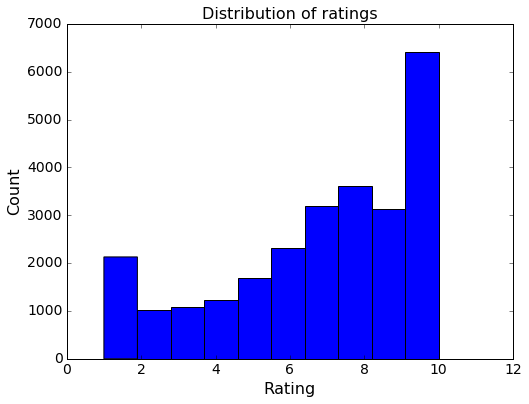

In [66]:
# Distribution of ratings
# remove nan rating
df_remove_nan_rating = df_review[df_review['rating'].isnull() == False]
plt.hist(df_remove_nan_rating['rating'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title('Distribution of ratings')

In [67]:
# mean and standard deviation of ratings
print np.mean(df_remove_nan_rating['rating'])
print np.std(df_remove_nan_rating['rating'])

6.90655725014
2.87299501904


On a scale range from 1.0 to 10.0, the average rating is 6.90. The standard deviation is 2.87.
We can plot the distribution of mean ratings for movies.

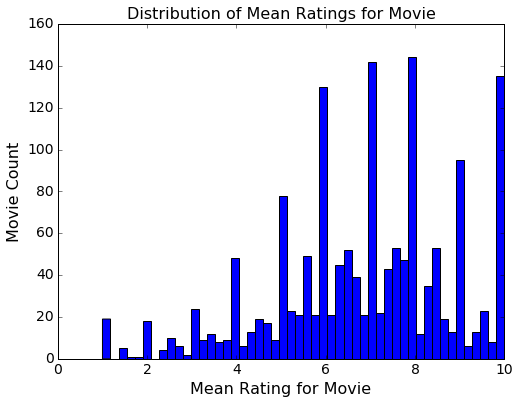

In [75]:
mean_rating = pd.DataFrame(M).replace('0', np.nan).mean(axis=0)
plt.hist(mean_rating, bins=50)
plt.xlabel("Mean Rating for Movie")
plt.ylabel("Movie Count")
plt.title('Distribution of Mean Ratings for Movie')

we can also plot the distribution of number of ratings per user.

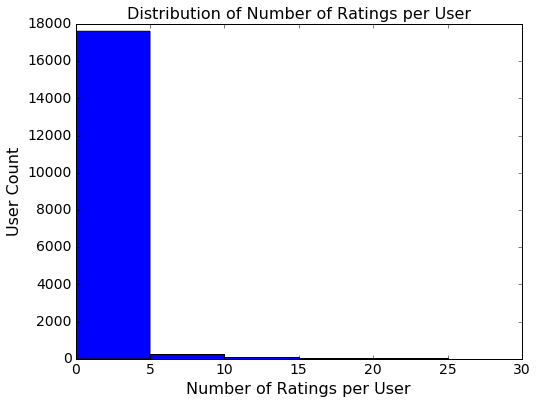

In [85]:
num_of_rating = pd.DataFrame(M).replace('0', np.nan).count(axis=1)
plt.hist(num_of_rating, bins=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Number of Ratings per User")
plt.ylabel("User Count")
plt.title('Distribution of Number of Ratings per User')

From the diagram, we can see that most of the user has less than 5 ratings. This caused our rating matrix very sparse.

We can check the top 10 movie with the highest review count. 

Title : Pulp Fiction
Review Count : 2227


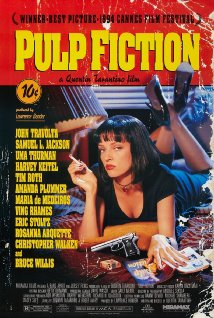

Title : Taxi Driver
Review Count : 886


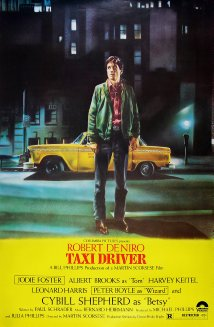

Title : Léon: The Professional
Review Count : 849


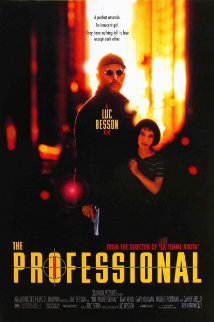

Title : Walk the Line
Review Count : 815


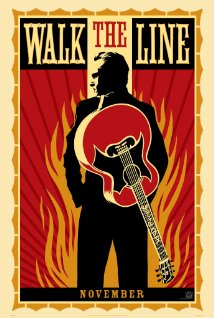

Title : The Haunting
Review Count : 806


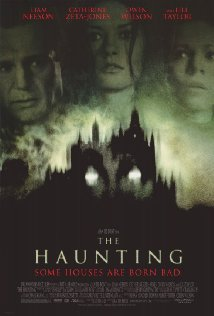

Title : I, Robot
Review Count : 789


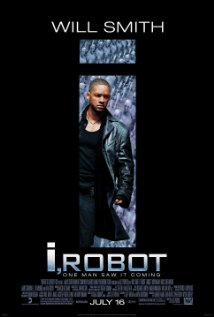

Title : Click
Review Count : 686


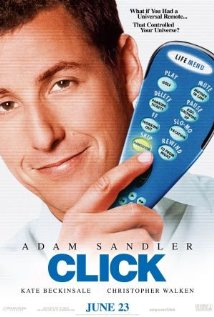

Title : A Knight's Tale
Review Count : 659


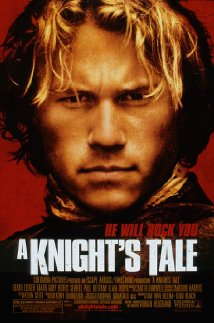

Title : Dogville
Review Count : 609


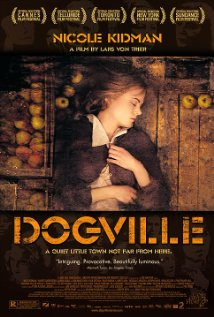

Title : Dungeons & Dragons
Review Count : 589


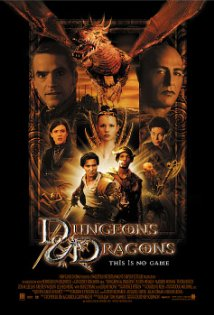

In [200]:
def display_top_k_most_reviewed_movie(k):
    idx = 0
    # some of the movies do not have a poster, we just ignore these kinds of movies
    total_cnt = 0
    reviews = df_review['imdb_id'].value_counts()
    movies = reviews.index
    
    while total_cnt < k:
        row = df_movie[df_movie['imdb_id'] == movies[idx]]
        if row['cover_url'].iloc[0]:
            title = row['title'].iloc[0]
            if title:
                print "Title : " + title
            print "Review Count : " + str(reviews[movies[idx]])
            display(Image(row['cover_url'].iloc[0]))
            total_cnt += 1
        idx += 1
    return
display_top_k_most_reviewed_movie(10)

We can also check the top 10 movie with the highest average ratings. 

/Users/apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Title : P.A.T.R.I.O.T
Runtime : nan


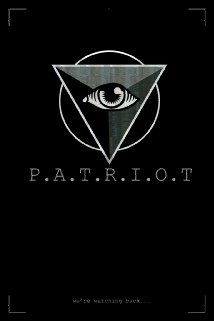

Title : Heartbeat
Runtime : 240.0


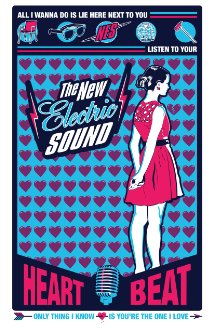

Title : Light Study
Runtime : 840.0


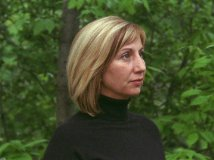

Title : Totem
Runtime : 360.0


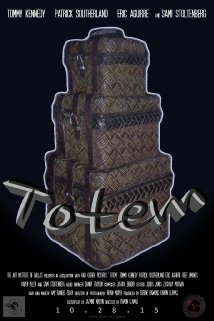

Title : Savor
Runtime : 60.0


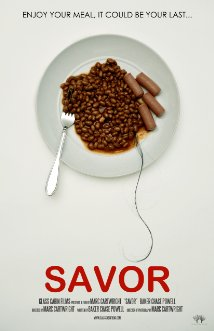

Title : Lost: 10th Anniversary Reunion - Cast and Creators Live at PaleyFest
Runtime : 4080.0


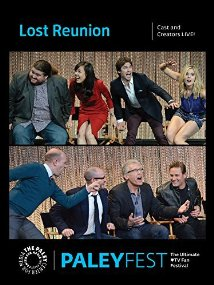

Title : Induction
Runtime : 1020.0


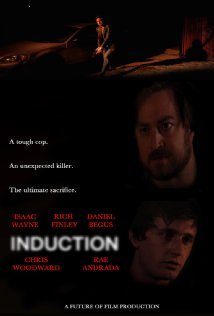

Title : Sveriges Bästa Svensk
Runtime : 1920.0


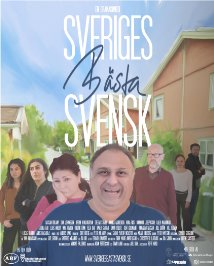

Title : Operation A.N.G.E.L
Runtime : 1500.0


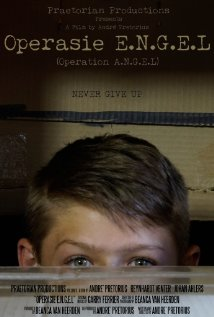

Title : K&P
Runtime : 720.0


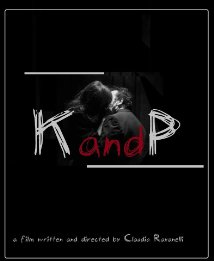

In [172]:
def display_top_k_movie_with_highest_rating(k):
    idx = 0
    # some of the movies do not have a poster, we just ignore these kinds of movies
    total_cnt = 0
    # sort the dataframe by rating descending
    sorted_movie = df_movie.sort('rating', ascending=False)['imdb_id'].values
    
    while total_cnt < k:
        cover_url = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['cover_url'].iloc[0]
        if cover_url:
            title = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['title'].iloc[0]
            if title:
                print "Title : " + title
            runtime = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['runtime'].iloc[0]
            if runtime:
                print "Runtime : " + str(runtime)
            display(Image(cover_url))
            total_cnt += 1
        idx += 1
    return
display_top_k_movie_with_highest_rating(10)

We can also check the top 10 active users who has the most number of reviews.

In [202]:
def display_top_k_most_active_users(k):
    total_cnt = 0
    reviews = df_review['username'].value_counts()
    users = reviews.index
    
    while total_cnt < k:
        print users[total_cnt]
        total_cnt += 1
        
    return
display_top_k_most_active_users(10)

planktonrules
Michael_Elliott
bkoganbing
anonymous
SnoopyStyle
TheLittleSongbird
Leofwine_draca
Claudio Carvalho
bob the moo
gavin6942
